In [112]:
import json
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy
from utils import run_model, match_dates_based_on_precision, parse_date
import pandas as pd

In [113]:
nlp = spacy.load('en_core_web_trf')

In [114]:
base_model_v2 = 'allenai/unifiedqa-v2-t5-base-1251000'
large_model_v2  = 'allenai/unifiedqa-v2-t5-large-1251000'
threeb_model_v2 = 'allenai/unifiedqa-v2-t5-3b-1251000'

In [115]:
base_tokenizer = T5Tokenizer.from_pretrained(base_model_v2)
base_model = T5ForConditionalGeneration.from_pretrained(base_model_v2)

In [116]:
large_tokenizer = T5Tokenizer.from_pretrained(large_model_v2)
large_model = T5ForConditionalGeneration.from_pretrained(large_model_v2)

In [117]:
threeb_tokenizer = T5Tokenizer.from_pretrained(threeb_model_v2)
threeb_model = T5ForConditionalGeneration.from_pretrained(threeb_model_v2)

In [118]:
annotated_df = pd.read_csv('../data/questions-for-annotation-annotated.csv')
len(annotated_df)

100

In [119]:
def run_unified_qa(annotated_df):
    out = []
    for question,answer,precision,dpr_answer,answerable,rank,filtered_rank in zip(annotated_df['question'],
                                                                                 annotated_df['answer'],
                                                                                 annotated_df['precision'],
                                                                                 annotated_df['dpr_answer'],
                                                                                 annotated_df['answerable'],
                                                                                 annotated_df['rank'],
                                                                                 annotated_df['filtered_rank']):
        r = { 
            'question': question,
            'answer': answer,
            'precision': precision,
            'dpr_answer': dpr_answer,
            'answerable': answerable,
            'rank': rank,
            'filtered_rank': filtered_rank
             
        }
        unified_qa_string = f"{question}\n{dpr_answer}"
        base_answer = run_model(unified_qa_string, base_tokenizer, base_model)
        r['base_answer'] = base_answer[0]
        base_parsed_date =parse_date(base_answer[0], nlp)
        if len(base_parsed_date) > 0:
            base_matched, base_prov = match_dates_based_on_precision(answer, precision, base_parsed_date[0])
            r['base_matched'] = base_matched
        else:
            r['base_matched'] = False
            
        large_answer = run_model(unified_qa_string, large_tokenizer, large_model)
        r['large_answer'] = large_answer[0]
        large_parsed_date =parse_date(large_answer[0], nlp)
        if len(large_parsed_date) > 0:
            large_matched, large_prov = match_dates_based_on_precision(answer, precision, large_parsed_date[0])
            r['large_matched'] = large_matched
        else:
            r['large_matched'] = False
            
        threeb_answer = run_model(unified_qa_string, threeb_tokenizer, threeb_model)
        r['threeb_answer'] = threeb_answer[0]
        threeb_parsed_date =parse_date(threeb_answer[0], nlp)
        if len(threeb_parsed_date) > 0:
            threeb_matched, threeb_prov = match_dates_based_on_precision(answer, precision, threeb_parsed_date[0])
            r['threeb_matched'] = threeb_matched
        else:
            r['threeb_matched'] = False
        out.append(r)
            
    return pd.DataFrame(out)

In [120]:
ans_df = run_unified_qa(annotated_df)

/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [121]:
ans_df

,question,answer,precision,dpr_answer,answerable,rank,filtered_rank,base_answer,base_matched,large_answer,large_matched,threeb_answer,threeb_matched
0,when did Tommy Dorsey marry Patricia?,1943-01-01,year,Tommy Dorsey New Jersey. They divorced in 1943...,yes,1,1,1943,True,1943,True,1943,True
1,when did Edward Everett Hale marry Emily Baldwin?,1852-01-01,year,"Edward Everett Hale Unity in Worcester, Massac...",yes,1,1,1852,True,1852,True,1852,True
2,when did Denys Rhodes marry Margaret?,1950-07-31,day,Denys Rhodes Rhodes. Rhodes served in the Seco...,yes,24,1,31 July 1950,True,31 July 1950,True,31 July 1950,True
3,when did Ronald Tree marry Marietta Peabody?,1947-01-01,year,"Ronald Tree improved, notably including coveri...",yes,3,1,1946,False,1946,False,1947,True
4,"when did Francis Jeune, 1st Baron St Helier ma...",1881-08-17,day,"Francis Jeune, 1st Baron St Helier Bath (KCB)....",yes,1,1,1881,False,1891,False,1897,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"when did John Dewar, 1st Baron Forteviot marry...",1884-06-24,day,"John Dewar, 1st Baron Forteviot John Dewar, 1s...",yes,33,1,24 June 1884,True,24 June 1884,True,24 June 1884,True
96,when did Doutzen Kroes marry Sunnery James?,2010-01-01,year,Doutzen Kroes is actively involved with the no...,yes,85,1,Eastermar,False,2010,True,7 November 2010,True
97,"when did Mary Eccles, Viscountess Eccles marry...",1939-01-01,year,"Mary Eccles, Viscountess Eccles in 1992. Eccle...",yes,16,1,1939,True,1939,True,1939,True
98,when did Carol Wayne marry Burt?,1975-01-01,year,"Carol Wayne Heartbreakers. In January 1984, Wa...",yes,2,1,1975,True,1975,True,1975,True


In [150]:
len(ans_df[(ans_df['base_matched'] == True) & (ans_df['answerable'] == 'yes')]) / len(ans_df[ans_df['answerable'] == 'yes'])

0.8117647058823529

In [151]:
len(ans_df[(ans_df['large_matched'] == True) & (ans_df['answerable'] == 'yes')]) / len(ans_df[ans_df['answerable'] == 'yes'])

0.8

In [152]:
len(ans_df[(ans_df['threeb_matched'] == True) & (ans_df['answerable'] == 'yes')]) / len(ans_df[ans_df['answerable'] == 'yes'])

0.9176470588235294

In [125]:
ans_df.to_csv('../data/questions-for-annotation-annotated-unified-qa.csv', index=False)

In [126]:
ans_df['precision'].value_counts()

year     59
day      37
month     4
Name: precision, dtype: int64

In [127]:
ans_df['answerable'].value_counts()

yes    85
no     15
Name: answerable, dtype: int64

In [128]:
annotated_df = pd.read_csv('../data/questions-for-annotation-annotated-unified-qa.csv')

In [129]:
len(annotated_df)

100

In [130]:
annotated_df['precision'].value_counts()

year     59
day      37
month     4
Name: precision, dtype: int64

In [131]:
annotated_df['answerable'].value_counts()

yes    85
no     15
Name: answerable, dtype: int64

In [132]:
answerable_values = list(annotated_df['answerable'].unique())
models = ['base_matched', 'large_matched', 'threeb_matched']

In [134]:
plot = []
for model in models:
    for av in answerable_values:
        plot.append({'model': model, 'answerable': av, 'matched':True, 'count': len(annotated_df[(annotated_df[model] == True) & (annotated_df['answerable'] == av)])})
        plot.append({'model': model, 'answerable': av, 'matched':False, 'count': len(annotated_df[(annotated_df[model] == False) & (annotated_df['answerable'] == av)])})
plot_df = pd.DataFrame(plot) 

Answerable keywords:
- yes: question is answerable given the dpr answer
- no: question is not answerable given the dpr answer
- check: question would have been answerable given better sentence splits
- interesting: dpr answer is vague about the answer
- invalid: question is invalid because of incorrect first name of second qnode
- incorrect: dpr answer has wrong information (wikipedia obsolete/incorrect)

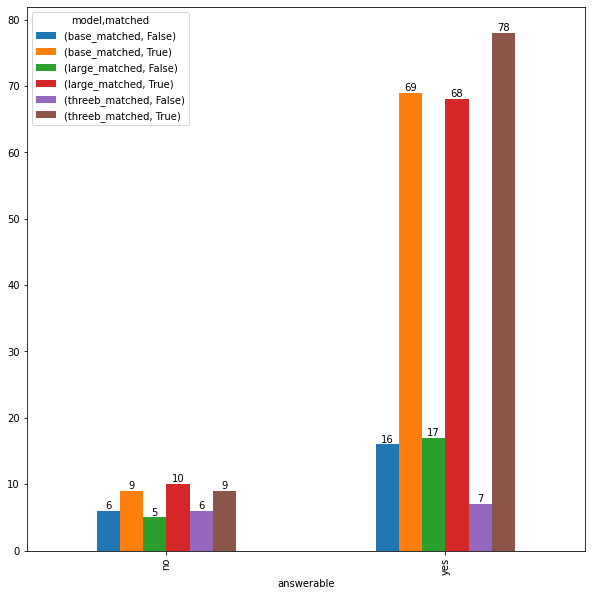

In [135]:
pivot_plot_df = pd.pivot_table(plot_df, 
                               values='count', 
                               index=['answerable'],
                               columns=["model", "matched"])
ax = pivot_plot_df.plot(kind="bar", figsize=(10,10))
for c in ax.containers:
    ax.bar_label(c)

In [139]:
annotated_df

,question,answer,precision,dpr_answer,answerable,rank,filtered_rank,base_answer,base_matched,large_answer,large_matched,threeb_answer,threeb_matched
0,when did Tommy Dorsey marry Patricia?,1943-01-01,year,Tommy Dorsey New Jersey. They divorced in 1943...,yes,1,1,1943,True,1943,True,1943,True
1,when did Edward Everett Hale marry Emily Baldwin?,1852-01-01,year,"Edward Everett Hale Unity in Worcester, Massac...",yes,1,1,1852,True,1852,True,1852,True
2,when did Denys Rhodes marry Margaret?,1950-07-31,day,Denys Rhodes Rhodes. Rhodes served in the Seco...,yes,24,1,31 July 1950,True,31 July 1950,True,31 July 1950,True
3,when did Ronald Tree marry Marietta Peabody?,1947-01-01,year,"Ronald Tree improved, notably including coveri...",yes,3,1,1946,False,1946,False,1947,True
4,"when did Francis Jeune, 1st Baron St Helier ma...",1881-08-17,day,"Francis Jeune, 1st Baron St Helier Bath (KCB)....",yes,1,1,1881,False,1891,False,1897,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"when did John Dewar, 1st Baron Forteviot marry...",1884-06-24,day,"John Dewar, 1st Baron Forteviot John Dewar, 1s...",yes,33,1,24 June 1884,True,24 June 1884,True,24 June 1884,True
96,when did Doutzen Kroes marry Sunnery James?,2010-01-01,year,Doutzen Kroes is actively involved with the no...,yes,85,1,Eastermar,False,2010,True,7 November 2010,True
97,"when did Mary Eccles, Viscountess Eccles marry...",1939-01-01,year,"Mary Eccles, Viscountess Eccles in 1992. Eccle...",yes,16,1,1939,True,1939,True,1939,True
98,when did Carol Wayne marry Burt?,1975-01-01,year,"Carol Wayne Heartbreakers. In January 1984, Wa...",yes,2,1,1975,True,1975,True,1975,True


day
month
year


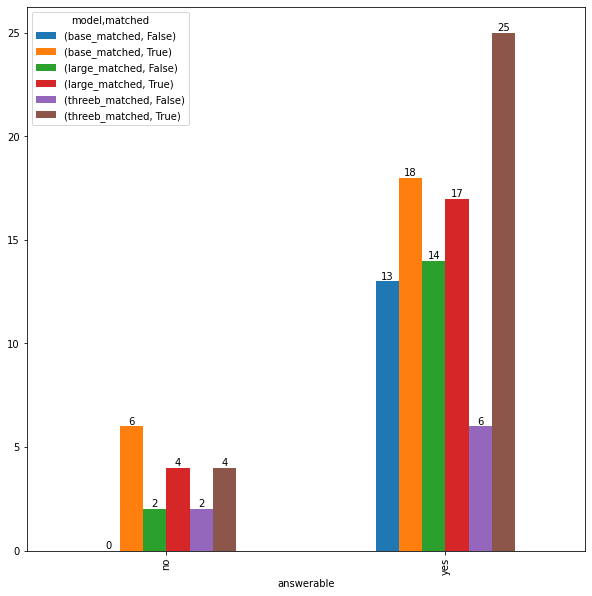

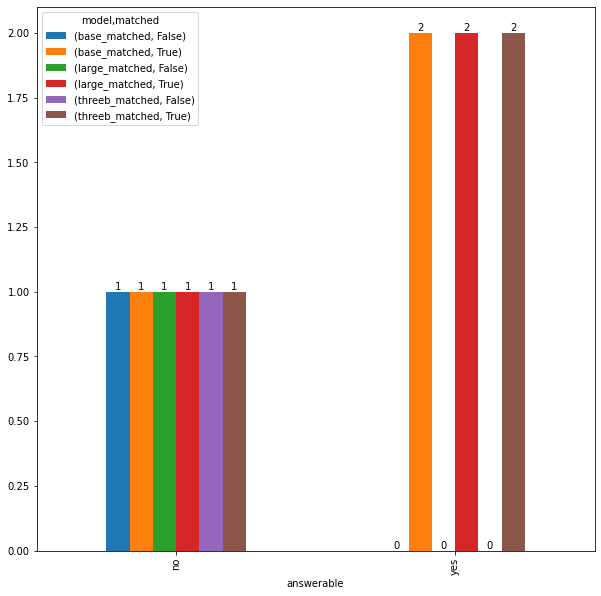

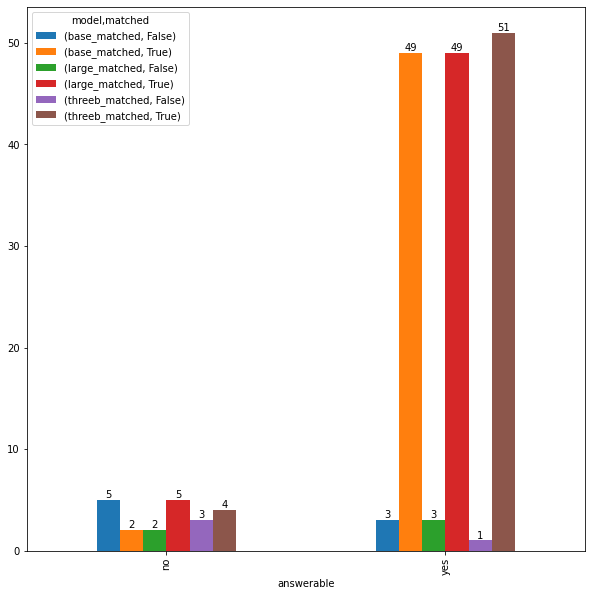

In [145]:
for precision, dff in annotated_df.groupby(by='precision'):
    plot = []
    for model in models:
        for av in answerable_values:
            plot.append({'model': model, 
                     'answerable': av, 
                     'matched':True, 
                     'count': len(dff[(dff[model] == True) & (dff['answerable'] == av)])})
            plot.append({'model': model, 
                         'answerable': av, 
                         'matched':False, 
                         'count': len(dff[(dff[model] == False) & (dff['answerable'] == av)])})
    plot_df_2 = pd.DataFrame(plot)
    pivot_plot_df_2 = pd.pivot_table(plot_df_2, 
                               values='count', 
                               index=['answerable'],
                               columns=["model", "matched"])
    print(precision)
    ax = pivot_plot_df_2.plot(kind="bar", figsize=(10,10))
    for c in ax.containers:
        ax.bar_label(c)

In [146]:
annotated_df['precision'].value_counts()

year     59
day      37
month     4
Name: precision, dtype: int64

In [153]:
78/85

0.9176470588235294